In [1]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [2]:
import os
import sys

if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.1 MB/s eta 0:00:00


In [3]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


In [4]:
import os
import kagglehub

LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"

if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR}")

100%|██████████| 5.65G/5.65G [00:39<00:00, 155MB/s] 


Model path: /root/.cache/kagglehub/models/google/paligemma-2/jax/paligemma2-3b-pt-224/1/./paligemma2-3b-pt-224.b16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model
Data path: ./longcap100


In [5]:

model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

params = paligemma.load(None, MODEL_PATH, model_config)

decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [6]:

def is_trainable_param(name, param):
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [7]:
def preprocess_image(image, size=224):
  image = np.asarray(image)
  if image.ndim == 2:
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)
  mask_loss = [0] * len(tokens)

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)
    mask_loss += [1] * len(suffix)

  mask_input = [1] * len(tokens)
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()
  try:
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [8]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_train90.jsonl"),
    fopen_keys={"image": DATA_DIR})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_val10.jsonl"),
    fopen_keys={"image": DATA_DIR})


def train_data_iterator():
  """Never ending iterator over training examples."""
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "caption en"
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "caption en"
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


Training examples



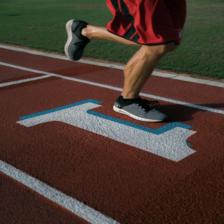
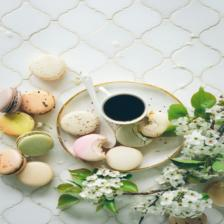
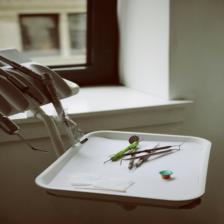
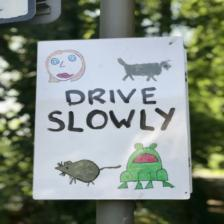
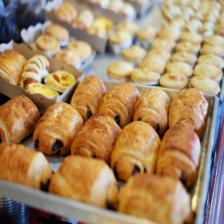
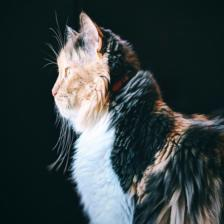
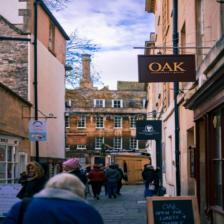
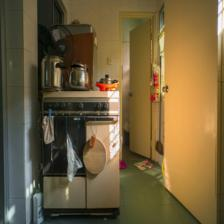

In [9]:
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])
  caption = caption[len("caption en\n"):]
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [10]:
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    token_pplx = jnp.sum(logp * targets, axis=-1)
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)

    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)
    except StopIteration:
      if len(examples) == 0:
        return outputs

    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]
    responses = [postprocess_tokens(t) for t in tokens]

    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

step:  1/64   lr: 0.00500   loss: 3.3277
step:  2/64   lr: 0.01000   loss: 1.8770
step:  3/64   lr: 0.01500   loss: 1.6623
step:  4/64   lr: 0.02000   loss: 1.7120
step:  5/64   lr: 0.02500   loss: 1.5212
step:  6/64   lr: 0.03000   loss: 1.6843
step:  7/64   lr: 0.02998   loss: 1.9567
step:  8/64   lr: 0.02992   loss: 1.4442
step:  9/64   lr: 0.02981   loss: 1.4881
step: 10/64   lr: 0.02966   loss: 1.3914
step: 11/64   lr: 0.02947   loss: 1.4693
step: 12/64   lr: 0.02924   loss: 1.3693
step: 13/64   lr: 0.02897   loss: 0.9716
step: 14/64   lr: 0.02866   loss: 1.2156
step: 15/64   lr: 0.02831   loss: 1.0839
step: 16/64   lr: 0.02792   loss: 1.1471
Model predictions at step 16



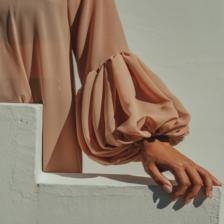
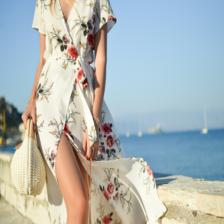
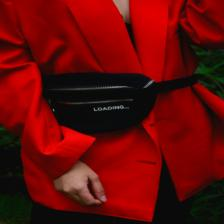
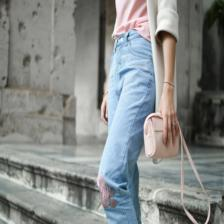

step: 17/64   lr: 0.02750   loss: 1.1991
step: 18/64   lr: 0.02704   loss: 0.9493
step: 19/64   lr: 0.02655   loss: 1.1160
step: 20/64   lr: 0.02602   loss: 1.0122
step: 21/64   lr: 0.02546   loss: 1.1070
step: 22/64   lr: 0.02488   loss: 1.0433
step: 23/64   lr: 0.02426   loss: 0.9465
step: 24/64   lr: 0.02362   loss: 0.7706
step: 25/64   lr: 0.02296   loss: 0.6658
step: 26/64   lr: 0.02227   loss: 0.7141
step: 27/64   lr: 0.02156   loss: 0.6121
step: 28/64   lr: 0.02083   loss: 0.6990
step: 29/64   lr: 0.02009   loss: 0.7291
step: 30/64   lr: 0.01933   loss: 0.7535
step: 31/64   lr: 0.01856   loss: 0.6374
step: 32/64   lr: 0.01778   loss: 0.6023
Model predictions at step 32



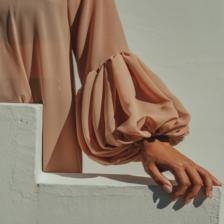
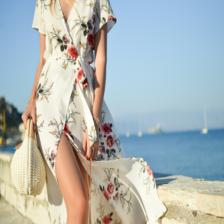
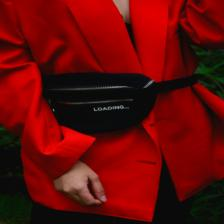
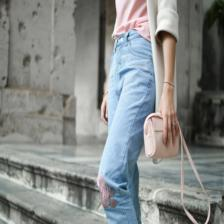

step: 33/64   lr: 0.01699   loss: 0.6248
step: 34/64   lr: 0.01620   loss: 0.5062
step: 35/64   lr: 0.01540   loss: 0.4084
step: 36/64   lr: 0.01460   loss: 0.4086
step: 37/64   lr: 0.01380   loss: 0.4087
step: 38/64   lr: 0.01301   loss: 0.3075
step: 39/64   lr: 0.01222   loss: 0.3100
step: 40/64   lr: 0.01144   loss: 0.3774
step: 41/64   lr: 0.01067   loss: 0.3091
step: 42/64   lr: 0.00991   loss: 0.2914
step: 43/64   lr: 0.00917   loss: 0.3481
step: 44/64   lr: 0.00844   loss: 0.3350
step: 45/64   lr: 0.00773   loss: 0.3306
step: 46/64   lr: 0.00704   loss: 0.1898
step: 47/64   lr: 0.00638   loss: 0.1174
step: 48/64   lr: 0.00574   loss: 0.1918
Model predictions at step 48



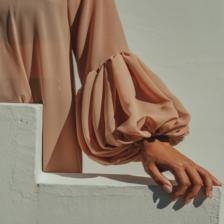
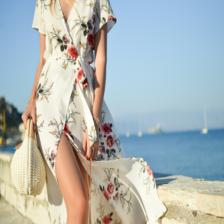
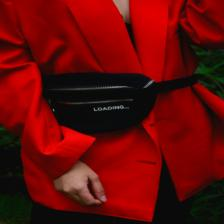
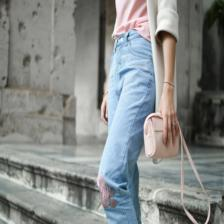

step: 49/64   lr: 0.00512   loss: 0.1427
step: 50/64   lr: 0.00454   loss: 0.1199
step: 51/64   lr: 0.00398   loss: 0.2314
step: 52/64   lr: 0.00345   loss: 0.1486
step: 53/64   lr: 0.00296   loss: 0.1548
step: 54/64   lr: 0.00250   loss: 0.1087
step: 55/64   lr: 0.00208   loss: 0.1156
step: 56/64   lr: 0.00169   loss: 0.1693
step: 57/64   lr: 0.00134   loss: 0.0893
step: 58/64   lr: 0.00103   loss: 0.1062
step: 59/64   lr: 0.00076   loss: 0.0806
step: 60/64   lr: 0.00053   loss: 0.0742
step: 61/64   lr: 0.00034   loss: 0.0912
step: 62/64   lr: 0.00019   loss: 0.0749
step: 63/64   lr: 0.00008   loss: 0.1254
step: 64/64   lr: 0.00002   loss: 0.0783
Model predictions at step 64



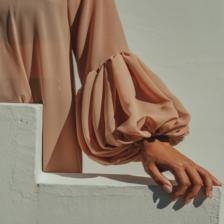
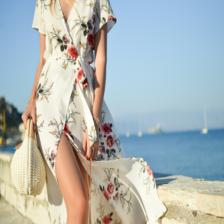
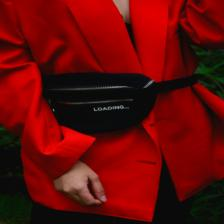
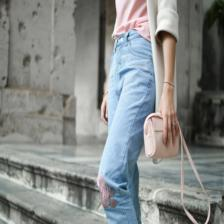

CPU times: user 8min 6s, sys: 15.6 s, total: 8min 21s
Wall time: 3min 14s


In [11]:
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.03

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


Model predictions



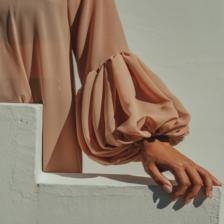
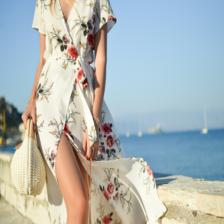
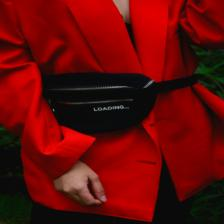
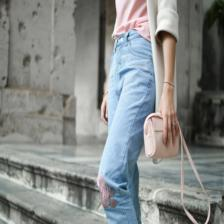
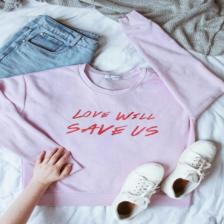
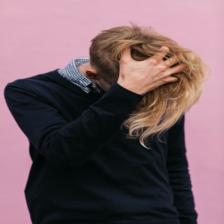
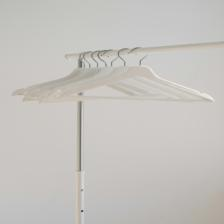
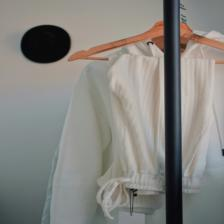
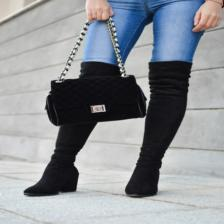
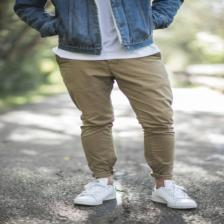

CPU times: user 6.03 s, sys: 284 ms, total: 6.32 s
Wall time: 6.7 s


In [12]:
%%time

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))
